In [1]:
# necessary imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from io import StringIO

### Load Data

In [2]:
df = pd.read_csv(os.path.join("clean_data", "final_data.csv"))

In [3]:
df.sample(5)

,timestamp,name,category,brightness,at_home,stress,valence,arousal,attention,pcode
10971,2019-05-11 14:23:53.301000+09:00,카카오페이지,BOOKS_AND_REFERENCE,LOW,False,0.0,1.0,0.0,0.0,P21
154099,2019-05-23 00:41:46.547000+09:00,네이버 웹툰,COMICS,LOW,True,1.0,0.0,0.0,0.0,P37
53100,2019-05-22 16:33:37.766000+09:00,NAVER,BOOKS_AND_REFERENCE,LOW,False,0.0,1.0,1.0,1.0,P42
37144,2019-05-02 18:14:07.963000+09:00,Facebook,SOCIAL,LOW,False,0.0,1.0,1.0,1.0,P72
41088,2019-05-11 00:23:15.307000+09:00,네이버 웹툰,COMICS,LOW,False,0.0,0.0,0.0,0.0,P11


## Descriptive Statistics

In [4]:
# number of data points
df.shape[0]

189861

In [5]:
df.describe(include="all")

,timestamp,name,category,brightness,at_home,stress,valence,arousal,attention,pcode
count,189861,189861,189861,189861,189861,189861.000000,189861.000000,189861.000000,189861.000000,189861
unique,189843,267,10,3,2,NaN,NaN,NaN,NaN,77
top,2019-05-16 23:34:27.647000+09:00,Facebook,SOCIAL,LOW,False,NaN,NaN,NaN,NaN,P56
freq,2,46992,107528,177576,152343,NaN,NaN,NaN,NaN,11036
mean,NaN,NaN,NaN,NaN,NaN,0.312797,0.549628,0.366310,0.472014,NaN
std,NaN,NaN,NaN,NaN,NaN,0.463634,0.497532,0.481797,0.499217,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN


### Distributions

In [6]:
def plot_distribution_of_values(col):
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show();

#### category

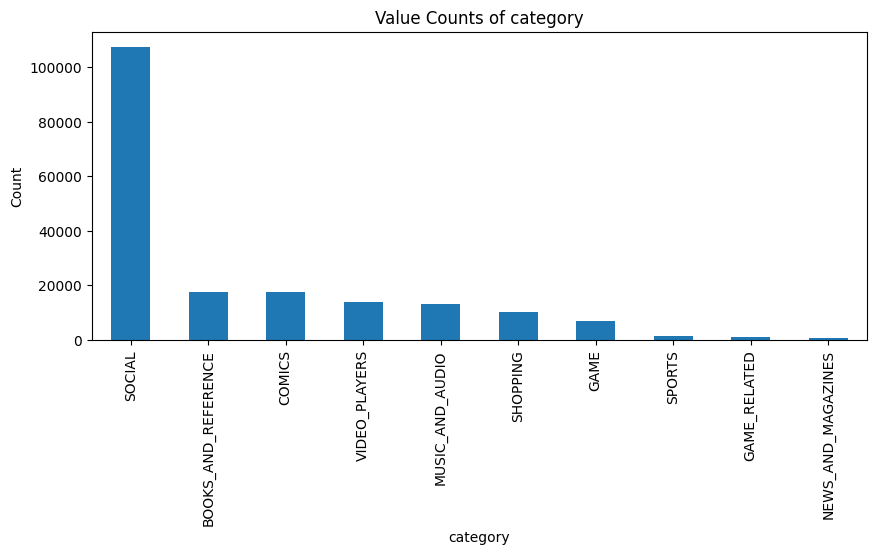

In [7]:
plot_distribution_of_values("category")

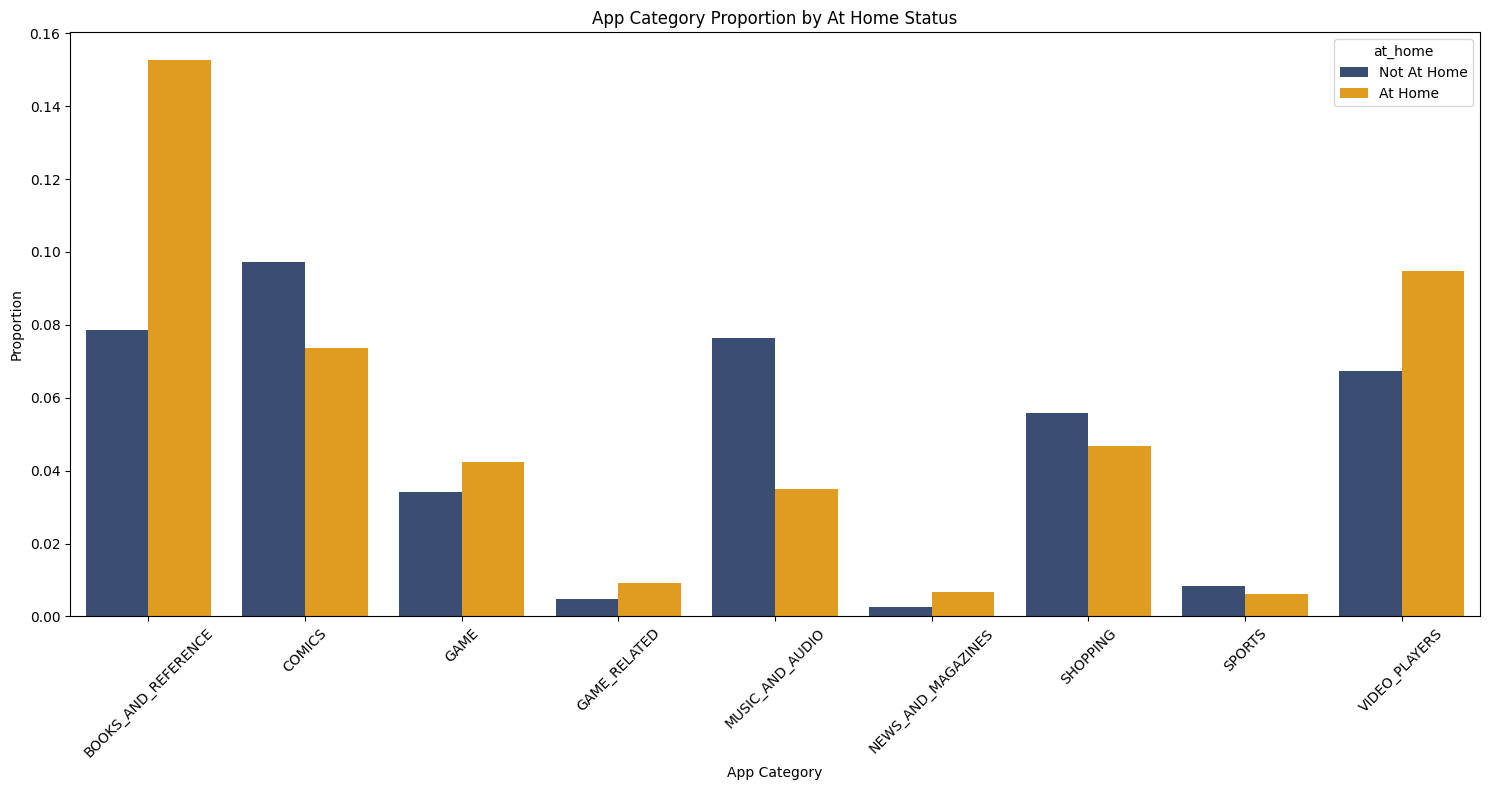

In [8]:
# Calculate the distributions
at_home_dist = df[df["at_home"]]["category"].value_counts()[1:] / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["category"].value_counts()[1:] / df[~df["at_home"]].shape[0]

# Create a DataFrame for plotting
dist_df = pd.DataFrame({
    'category': at_home_dist.index.tolist() + not_at_home_dist.index.tolist(),
    'proportion': at_home_dist.tolist() + not_at_home_dist.tolist(),
    'at_home': ['At Home'] * len(at_home_dist) + ['Not At Home'] * len(not_at_home_dist)
}).sort_values(by=["proportion"], ascending=False)

# Sort the DataFrame by app_category
dist_df = dist_df.sort_values(by=['category', 'at_home'], ascending=[True, False])

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='category', y='proportion', hue='at_home', data=dist_df, palette=['#2f4b7c', '#ffa600'])
plt.xlabel('App Category')
plt.ylabel('Proportion')
plt.title('App Category Proportion by At Home Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### brightness and at_home

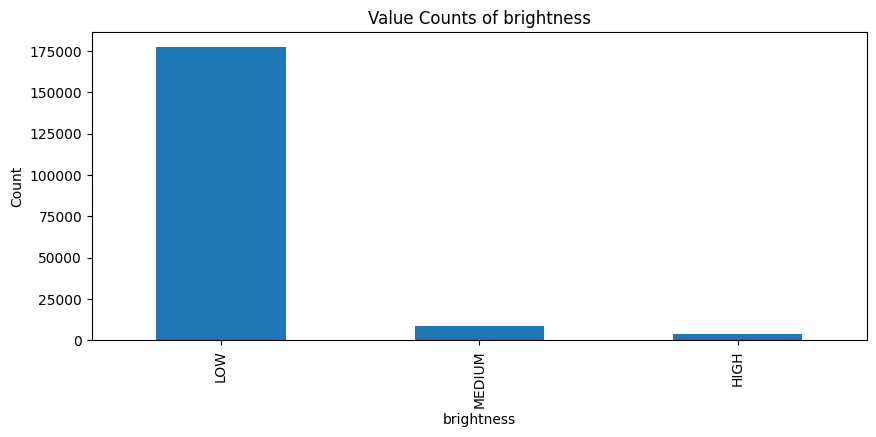

In [9]:
plot_distribution_of_values("brightness")

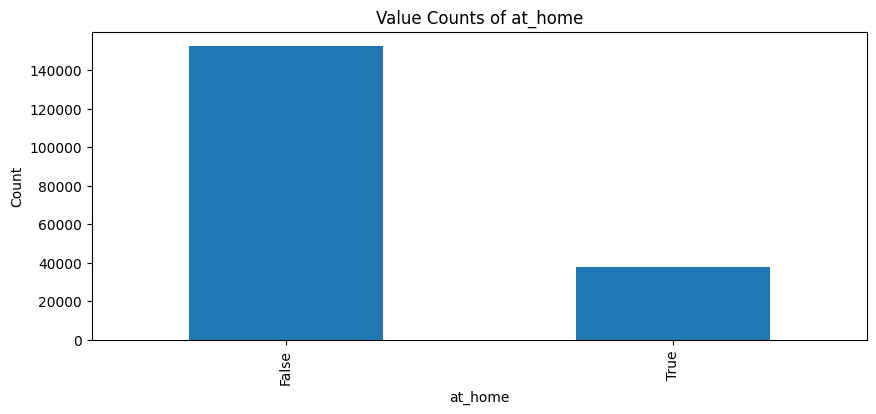

In [10]:
plot_distribution_of_values("at_home")

## Logisitc Regressions with Fixed Effects

- Main Effects: 
    - The models evaluates how app category, being at home and brightness levels influence whether people are stressed, feeling good (valence), attentive and aroused.

- Interaction Effects: 
    - They also evaluate whether the impact of using certain app categories on stress, valence, arousal, attention is different when the participant is at home versus elsewhere, or based on brightness levels.

- Individual Differences: 
    - The model controls for unique characteristics of each participant to get more accurate results.
    
Logistic regression is chosen because it is well-suited for modeling binary outcomes, such as whether a person is stressed (yes/no), feeling good (yes/no), attentive (yes/no), or aroused (yes/no). By using logistic regression, we can estimate the probability of these outcomes based on the predictors (app category, location, brightness) and their interactions. This method allows us to understand the relationship between the predictors and the binary outcomes while accounting for individual differences through fixed effects.

In [16]:
def generate_model(dv, with_brightness=False):
    if not with_brightness:
        formula = f"{dv} ~ C(category) * at_home + C(pcode)"
    else:
        formula = f"{dv} ~ C(category) * at_home + C(category) * C(brightness) + C(pcode)"
    return smf.logit(formula=formula, data=df).fit()

def get_model_results(model):
    html_string = model.summary().tables[1].as_html() # Extract the HTML from the model summary
    html_io = StringIO(html_string) # Use StringIO to wrap the HTML string
    df = pd.read_html(html_io, header=0)[0] # Read the HTML into a DataFrame
    df.columns = ["predictor"] + df.columns[1:].to_list() # Rename column
    return df[~df["predictor"].str.contains("pcode")]



In [17]:
def plot_forest(results_df):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Identify interaction effects
    interaction_effects = results_df[results_df['predictor'].str.contains(':')]

    # Plot main effects
    main_effects = results_df[~results_df['predictor'].str.contains(':')]
    main_effect_indices = range(len(main_effects))
    ax.errorbar(main_effects["coef"], main_effect_indices, xerr=1.96*main_effects["std err"], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

    # Plot interaction effects with a different color
    interaction_effect_indices = range(len(main_effects), len(main_effects) + len(interaction_effects))
    ax.errorbar(interaction_effects["coef"], interaction_effect_indices, xerr=1.96*interaction_effects["std err"], fmt='o', color='blue', ecolor='lightblue', elinewidth=3, capsize=0, alpha=0.7)

    # Add vertical line at zero
    ax.axvline(x=0, linestyle='--', color='red')

    # Combine main and interaction effects for y-ticks
    all_effects = pd.concat([main_effects, interaction_effects])
    ax.set_yticks(range(len(all_effects)))
    ax.set_yticklabels(all_effects['predictor'])

    # Add labels and title
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Predictor')
    ax.set_title('Forest Plot of Coefficient Estimates')

    # Highlight interaction effects with a light background
    for idx in interaction_effect_indices:
        ax.axhspan(idx - 0.5, idx + 0.5, color='lightgray', alpha=0.3)

    # Show plot
    plt.show()

### Stress

In [18]:
stress_model = generate_model("stress")
stress_results = get_model_results(stress_model)

Optimization terminated successfully.
         Current function value: 0.500040
         Iterations 7


In [19]:
# select only statistacally significant effects
stress_results[stress_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,-2.0689,0.233,-8.864,0.000,-2.526,-1.611
3,C(category)[T.GAME_RELATED],1.1210,0.096,11.687,0.000,0.933,1.309
4,C(category)[T.MUSIC_AND_AUDIO],0.4491,0.034,13.395,0.000,0.383,0.515
5,C(category)[T.NEWS_AND_MAGAZINES],1.0659,0.128,8.319,0.000,0.815,1.317
7,C(category)[T.SOCIAL],0.2109,0.027,7.670,0.000,0.157,0.265
8,C(category)[T.SPORTS],0.4265,0.078,5.450,0.000,0.273,0.580
9,C(category)[T.VIDEO_PLAYERS],0.3194,0.036,8.792,0.000,0.248,0.391
10,at_home[T.True],0.2775,0.043,6.486,0.000,0.194,0.361
89,C(category)[T.GAME_RELATED]:at_home[T.True],-1.3480,0.158,-8.514,0.000,-1.658,-1.038
90,C(category)[T.MUSIC_AND_AUDIO]:at_home[T.True],-1.0196,0.083,-12.242,0.000,-1.183,-0.856


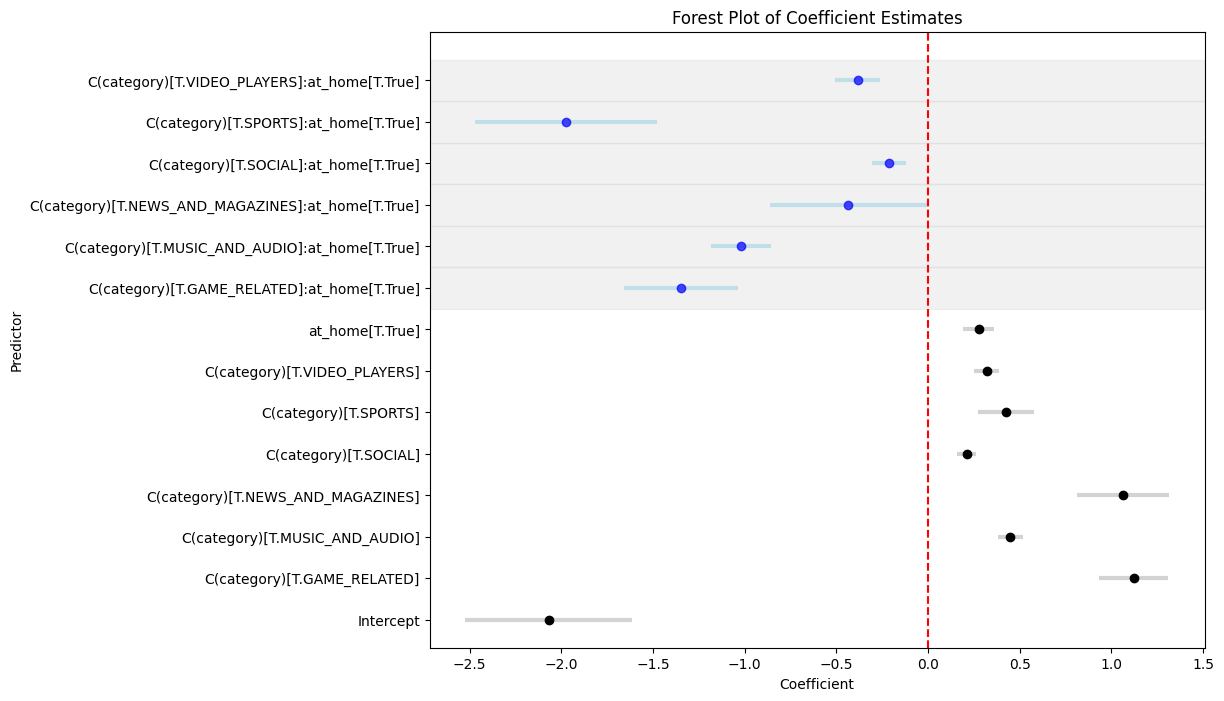

In [20]:
plot_forest(stress_results[stress_results["P>|z|"] < .05])

### Valence

In [21]:
valence_model = generate_model("valence", with_brightness=False)
valence_results = get_model_results(valence_model)

         Current function value: 0.533849
         Iterations: 35


/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# select only statistacally significant effects
valence_results[valence_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,1.8563,0.243,7.636,0.000,1.380,2.333
1,C(category)[T.COMICS],0.1076,0.036,2.997,0.003,0.037,0.178
3,C(category)[T.GAME_RELATED],-0.3977,0.088,-4.501,0.000,-0.571,-0.225
4,C(category)[T.MUSIC_AND_AUDIO],-0.1374,0.038,-3.646,0.000,-0.211,-0.064
6,C(category)[T.SHOPPING],0.0968,0.043,2.246,0.025,0.012,0.181
7,C(category)[T.SOCIAL],-0.1253,0.031,-4.065,0.000,-0.186,-0.065
8,C(category)[T.SPORTS],-0.6644,0.082,-8.099,0.000,-0.825,-0.504
10,at_home[T.True],-0.1763,0.043,-4.101,0.000,-0.261,-0.092
89,C(category)[T.GAME_RELATED]:at_home[T.True],1.4006,0.173,8.085,0.000,1.061,1.740
90,C(category)[T.MUSIC_AND_AUDIO]:at_home[T.True],0.9336,0.082,11.355,0.000,0.772,1.095


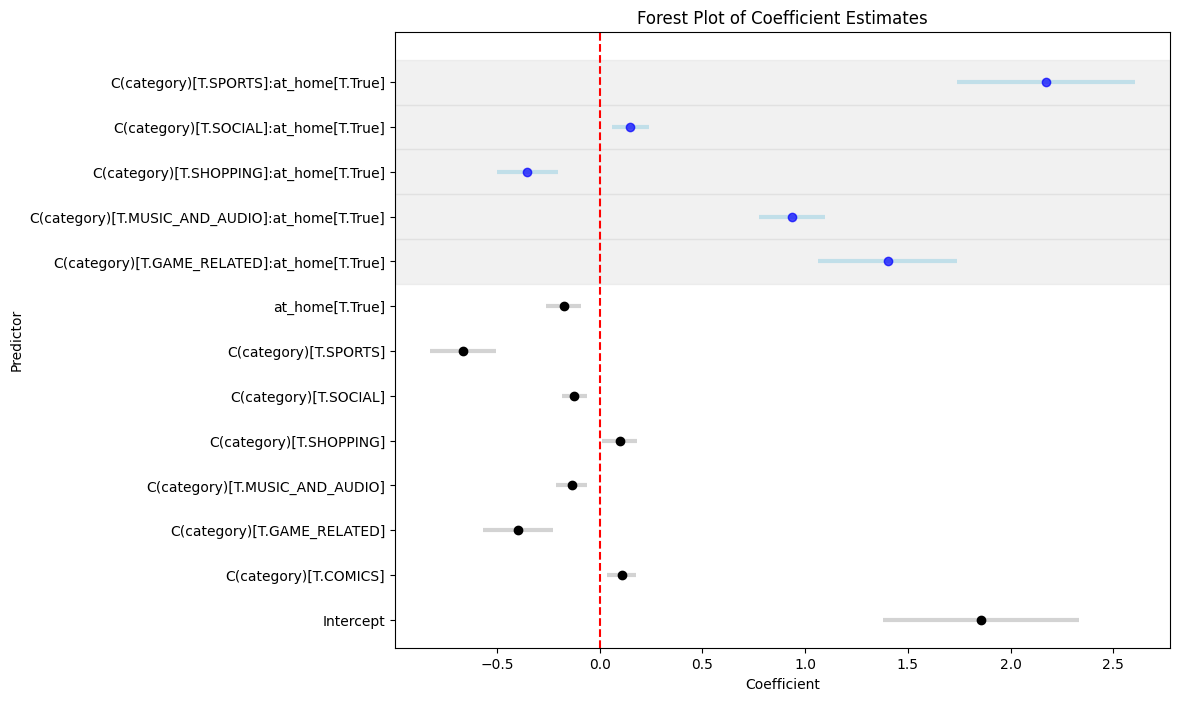

In [23]:
plot_forest(valence_results[valence_results["P>|z|"] < .05])

### Arousal

In [24]:
arousal_model = generate_model("arousal", with_brightness=False)
arousal_results = get_model_results(arousal_model)

Optimization terminated successfully.
         Current function value: 0.524407
         Iterations 9


In [25]:
# select only statistacally significant effects
arousal_results[arousal_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,0.5017,0.174,2.883,0.004,0.161,0.843
1,C(category)[T.COMICS],0.2706,0.034,7.958,0.000,0.204,0.337
2,C(category)[T.GAME],0.1737,0.041,4.274,0.000,0.094,0.253
3,C(category)[T.GAME_RELATED],-0.3670,0.126,-2.917,0.004,-0.614,-0.120
4,C(category)[T.MUSIC_AND_AUDIO],-0.2522,0.035,-7.161,0.000,-0.321,-0.183
6,C(category)[T.SHOPPING],-0.4937,0.042,-11.881,0.000,-0.575,-0.412
8,C(category)[T.SPORTS],-0.3977,0.082,-4.839,0.000,-0.559,-0.237
9,C(category)[T.VIDEO_PLAYERS],0.1180,0.037,3.211,0.001,0.046,0.190
10,at_home[T.True],-0.2210,0.047,-4.709,0.000,-0.313,-0.129
87,C(category)[T.COMICS]:at_home[T.True],-0.4129,0.069,-5.981,0.000,-0.548,-0.278


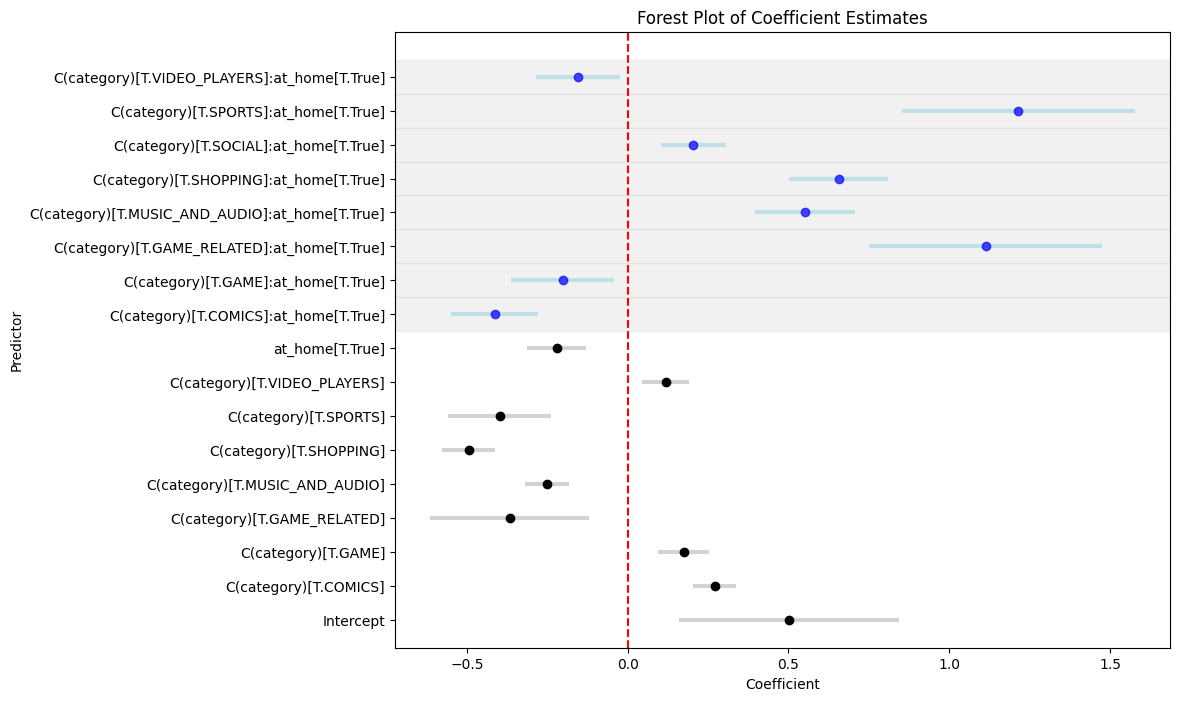

In [26]:
plot_forest(arousal_results[arousal_results["P>|z|"] < .05])

### Attention

In [27]:
attention_model = generate_model("attention")
attention_results = get_model_results(attention_model)

Optimization terminated successfully.
         Current function value: 0.582661
         Iterations 7


In [28]:
# select only statistacally significant effects
attention_results[attention_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,1.5165,0.218,6.945,0.000,1.089,1.945
1,C(category)[T.COMICS],0.2660,0.033,8.132,0.000,0.202,0.330
2,C(category)[T.GAME],-0.1860,0.040,-4.651,0.000,-0.264,-0.108
4,C(category)[T.MUSIC_AND_AUDIO],-0.1159,0.034,-3.446,0.001,-0.182,-0.050
5,C(category)[T.NEWS_AND_MAGAZINES],-0.3765,0.128,-2.942,0.003,-0.627,-0.126
6,C(category)[T.SHOPPING],-0.0944,0.039,-2.409,0.016,-0.171,-0.018
8,C(category)[T.SPORTS],-0.3566,0.071,-5.013,0.000,-0.496,-0.217
87,C(category)[T.COMICS]:at_home[T.True],-0.6019,0.063,-9.543,0.000,-0.725,-0.478
89,C(category)[T.GAME_RELATED]:at_home[T.True],0.4457,0.139,3.205,0.001,0.173,0.718
90,C(category)[T.MUSIC_AND_AUDIO]:at_home[T.True],1.0083,0.076,13.259,0.000,0.859,1.157


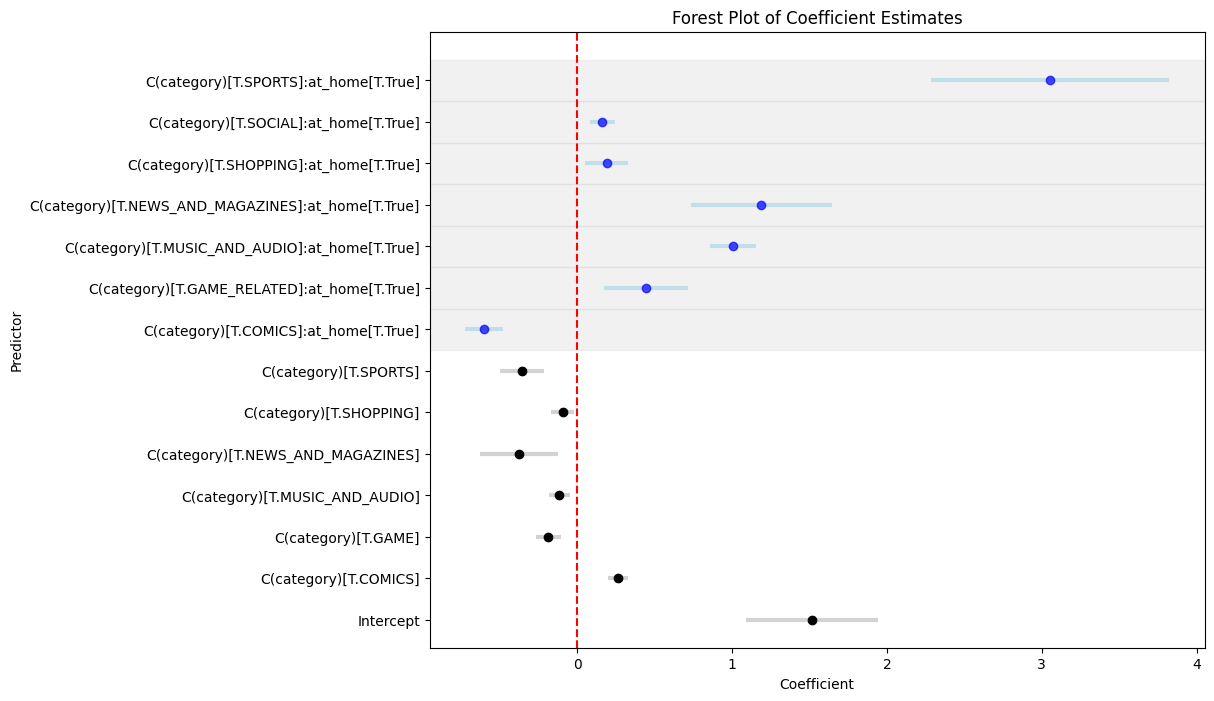

In [29]:
plot_forest(attention_results[attention_results["P>|z|"] < .05])